In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
import seaborn as sns
import numpy as np
import os

In [7]:
#Settings for the plots

#Set the path of the different folders
pathFiles = '../Files/SensitivityAnalysis/'
pathBoxplots = '../Files/Results/Plots/Boxplots/'

#Set the font to latex font
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
#Set the color scheme for  base model:  #00876C
#Set the color scheme for the ransomware attack: #4664AA

#Set the color scheme for the base model
baseColor = '#079EDE' #Color from KIT guidelines
ransomwareColor = '#A22223' #Color from KIT guidelines
thirdColor = '#00876C' #Color from KIT guidelines

pd.set_option('display.max_columns', None)

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

########################################################################################################################
# Main Settings
########################################################################################################################
kpi_columns = [
    'total_num_ed_patients_entered',
    'avg_total_waiting_time',
    'avg_waiting_time_ed',
    'avg_inward_utilization',
    'avg_icu_utilization',
    'throughput_overall',
    'ed_throughput_per_day',
    'mortality_rate',
    'rate_target_time_mts_full',
    'Rate_LWBS',
    'avg_door_to_doctor_time',
    'avg_waiting_time_icu',
    'avg_queue_length_ed',	
    'avg_queue_length_radio',
    'avg_queue_length_surgery',
    'avg_queue_length_lab',
    'rejected_Patients_ED',
    'postponed_Patients_RAD',
    'postponed_Patients_OR',
    'avg_edwin_score',
    'avg_doctor_utilization_surgery',
]

# Titles for plots
titles = [
    'Absolute Throughput of Patients Hospital-wide',
    'Absolute Throughput of Patient ED',
    'Absolute Hospital Arrivals',
    'Absolute ED Arrivals',
    'Mortality Rate',
    'Absolute Deaths',
    'LWBS Count',
    'ED Throughput',
    'ED Queue Length',
    'Radiology Queue Length',
    'Laboratory Queue Length',
    'Physician Queue Length',
    'Nursing Monitoring Queue Length',
    'Surgery Queue Length',
    'Average EDWIN Score',
    'Door-to-Doctor Time',
    'ICU Waiting Time',
    'Inward Utilization Rate',
    'ICU Utilization Rate',
    'ED Waiting Time',
    'Hospital-wide Waiting Time',
    'Hospital-wide Throughput',
    'Rate of MTS Target Time not Reached',
    'Rejected Patients ED',
    'Postponed Patients RAD',
    'Postponed Patients OR',
    'Postponed Patients LAB',
    'Surgoen Utilization Rate',
    'Radiologist Utilization Rate',
    'Xray Utilization Rate',
    'Lab Doctor Utilization Rate',
    'Lab Nurse Utilization Rate',
    'Rate LWBS',
    'Adjusted Hospital-wide Throughput',
    'Adjusted Hospital-wide Throughput without Rejected'
]

#SCENARIOS
parameters = ['DailyLAB', 'DailyOP', 'DailyRAD', 'ArrivalED']
parameters = ['DailyOP']
color_palette = sns.color_palette("hls", len(parameters))

In [8]:
# Function to preprocess data
def preprocess_data(file_path, department_label):
    df = pd.read_csv(file_path, index_col=False)
    #Check if archiv is in file_path
    df['Rate_LWBS'] = (df['total_num_lwbs'] * 100) / df['total_num_ed_patients_entered']    

    
    # Multiplity avg icu utilization by 100 to get percentage
    df['avg_icu_utilization'] = df['avg_icu_utilization'] * 100
    df['avg_inward_utilization'] = df['avg_inward_utilization'] * 100
    #df['avg_doctor_utilization_surgery'] = df['avg_doctor_utilization_surgery'] * 100
    #df['avg_doctor_utilization_radio'] = df['avg_doctor_utilization_radio'] * 100
    #df['avg_xray_utilization'] = df['avg_xray_utilization'] * 100
    #df['avg_nurse_utilization_lab'] = df['avg_nurse_utilization_lab'] * 100

    #Round the values to 0 decimals since only full patients are possible
    for kpi in [
        'avg_queue_length_ed', 'avg_queue_length_radio', 'avg_queue_length_lab',
        'avg_queue_length_surgery', 'throughput_overall', 'ed_throughput_per_day',
        'postponed_Patients_OR', 'postponed_Patients_RAD', 'rejected_Patients_ED']:
        df[kpi] = df[kpi].round(0)
    df['Parameter'] = department_label
    return df

def recalculate_mortality_rate(df_combined, pathFiles, departments):
    for dept in departments:
        # Read specific datasets for each department
        df_overall = read_specific_dataset(pathFiles, 'OverallTroughput', dept)
        df_deceased = read_specific_dataset(pathFiles, 'DeceasedPatients', dept)
        df_doctor_utilization = read_specific_dataset(pathFiles, 'EDDoctorUtilization', dept)


        # Calculate mortality rate
        mortality_rate = df_deceased['SUM'] * 100 / df_overall['SUM']
        # Update df_combined with new mortality rates for the specific department
        df_combined.loc[df_combined['Parameter'] == dept, 'MortalityRate'] = mortality_rate.values
        df_combined.loc[df_combined['Parameter'] == dept, 'avg_doctor_utilization'] = df_doctor_utilization['Mean'].values


    return df_combined

def read_specific_dataset(path, dataset_name, scenario_label):
    """
    Reads a specific dataset from the "Datasets" folder and returns it as a DataFrame.
    """
    file_path = os.path.join(path, f'{scenario_label}/Datasets/Dataset{dataset_name}.csv')
    
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return pd.DataFrame()  # Return an empty DataFrame if the file does not exist
    
    df = pd.read_csv(file_path, sep=",")  # Read the CSV file
    df = df.set_index(df.columns[0])  # Set the first column as the index
    df = df.reset_index(drop=True)  # Reset the index to remove the old index
    
    # Calculate SUM and Mean before adding them as columns
    sum_values = df.sum(axis=1)
    mean_values = df.mean(axis=1)
    
    # Add additional columns
    df['SUM'] = sum_values
    df['Mean'] = mean_values
    df['Parameter'] = scenario_label
    df['Dataset'] = f'Dataset{dataset_name}.csv'
    return df


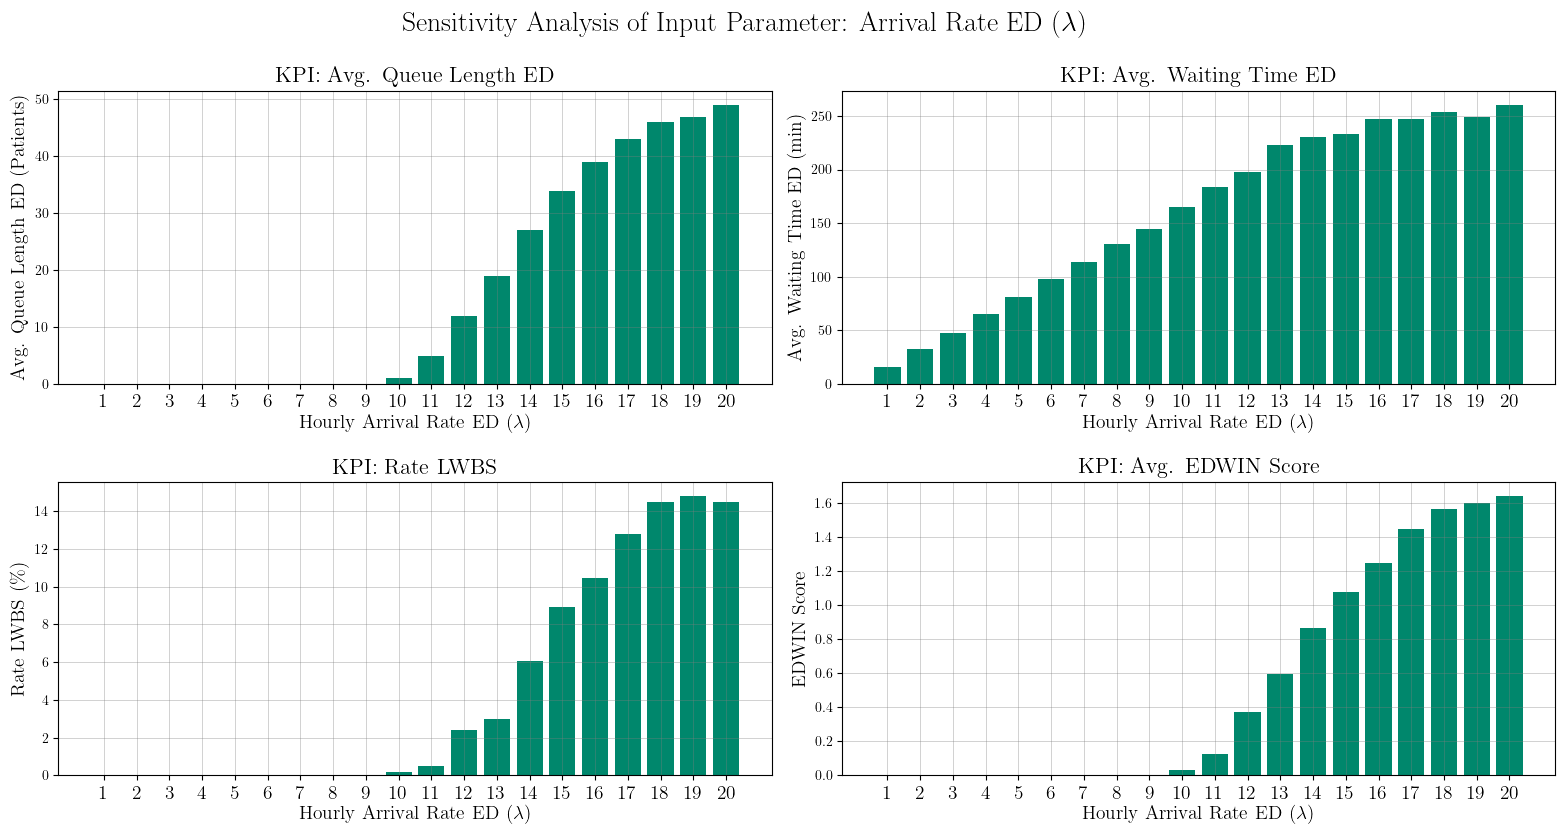

In [9]:
import os
import matplotlib.pyplot as plt

parameters = ['ArrivalED']

# Combine all MAIN KPIs
df_combined = pd.concat(
    [preprocess_data(f"{pathFiles}/{parameter}/MainKPIs/MainKPIs.csv", parameter) for parameter in parameters],
    ignore_index=True
)

def create_sensitivity_barcharts(df, parameters, kpi_columns, titles, output_dir='./sensitivity_plots/'):
    os.makedirs(output_dir, exist_ok=True)
    
    for param in parameters:
        param_data = df[df['Parameter'] == param]
        
        if param_data.empty:
            print(f"No data found for parameter: {param}")
            continue
        
        # Create a 2x2 subplot grid
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()

        fig.suptitle(f'Sensitivity Analysis of Input Parameter: Arrival Rate ED ($\lambda$)', fontsize=20, y=1)

        
        for ax, kpi, title in zip(axes, kpi_columns, titles):
            ax.bar(range(len(param_data)), param_data[kpi], color=thirdColor)
            ax.set_title(f'KPI: {title}', fontdict={'fontsize': 16, 'fontweight': 'bold'})  # Set title with bold font
            ax.title.set_position([0.5, 1.1])  # Adjust title position to add padding at the top
            ax.set_xlabel(f'Hourly Arrival Rate ED ($\lambda$)', fontsize=14)  # x-axis label
            ax.xaxis.set_label_coords(0.5, -0.1)  # Adjust x-axis label position
            # Set y-axis label based on KPI
            if 'Time' in title:
                ylabel = f'{title} (min)'
            elif 'Utilization' in title or 'utilization' in title:
                ylabel = f'{title} (\%)'
            elif 'Throughput' in title:
                ylabel = f'{title} (Patients/Day)'
            elif 'Rate' in title:
                ylabel = f'{title} (\%)'
            elif 'Queue' in title:
                ylabel = f'{title} (Patients)'
            elif 'EDWIN' in title:
                ylabel = 'EDWIN Score'
            else:
                ylabel = title  # default
            
            ax.set_ylabel(ylabel, fontsize=14)  # y-axis label
            
            # Define xtick_values based on parameter
            if param == 'ArrivalED':
                xtick_values = list(range(1, 21))
            elif param in ['DailyOP', 'DailyLAB', 'DailyRAD']:
                xtick_values = list(range(10, 201, 10))
            else:
                xtick_values = param_data['Parameter'].tolist()
            
            if len(xtick_values) != len(param_data):
                print(f"Mismatch in xtick values and data length for parameter: {param}")
                xtick_values = param_data['Parameter'].tolist()
            
            ax.set_xticks(range(len(xtick_values)))
            ax.set_xticklabels(xtick_values, fontsize=14)
            ax.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
            ax.set_facecolor('none')
            
            #for i, v in enumerate(param_data[kpi]):
            #    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')
        plt.subplots_adjust(hspace=0.3) 
        plt.tight_layout(rect=[0, 0.3, 1.05, 1.0])
        plt.savefig(f'{output_dir}{param}_sensitivity_4.pdf', format='pdf', bbox_inches='tight')
        plt.show()
        plt.close()

# Create plots
create_sensitivity_barcharts(
    df=df_combined,
    parameters=parameters,
    kpi_columns=['avg_queue_length_ed', 'ed_throughput_per_day', 'Rate_LWBS', 'avg_edwin_score'],
    titles=['Avg. Queue Length ED', 'Avg. Waiting Time ED', 'Rate LWBS', 'Avg. EDWIN Score']
)

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported for generating y-axis ticks

parameters = ['DailyOP']

# Combine all MAIN KPIs
df_combined = pd.concat(
    [preprocess_data(f"{pathFiles}/{parameter}/MainKPIs/MainKPIs.csv", parameter) for parameter in parameters],
    ignore_index=True
)

def create_sensitivity_barcharts(df, parameters, kpi_columns, titles, output_dir='./sensitivity_plots/'):
    os.makedirs(output_dir, exist_ok=True)
    
    for param in parameters:
        param_data = df[df['Parameter'] == param]
        
        if param_data.empty:
            print(f"No data found for parameter: {param}")
            continue
        
        # Create a 2x2 subplot grid
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()

        fig.suptitle(f'Sensitivity Analysis of Input Parameter: Arrival Rate OR ($\lambda$)', fontsize=20, y=1)
        
        for ax, kpi, title in zip(axes, kpi_columns, titles):

            colors = [thirdColor] * len(param_data)
            
            # Change color for the 6th bar if it exists
            bar_index = 5  # Zero-based index for the 6th bar
            if len(colors) > bar_index:
                colors[bar_index] = 'red' 

            ax.bar(range(len(param_data)), param_data[kpi], color=colors)
            ax.set_title(f'KPI: {title}', fontdict={'fontsize': 16, 'fontweight': 'bold'}, pad=15)  # Set title with bold font and padding
            ax.title.set_position([0.5, 1.1])  # Adjust title position to add padding at the top
            ax.set_xlabel(f'Arrival Rate OR ($\lambda$)', fontsize=14)  # x-axis label with padding
            ax.xaxis.set_label_coords(0.5, -0.1)  # Adjust x-axis label position
            # Set y-axis label based on KPI
            if 'Time' in title:
                ylabel = f'{title} (min)'
            elif 'Utilization' in title.lower():
                ylabel = f'{title} (%)'
            elif 'Throughput' in title:
                ylabel = f'{title} (Patients/Day)'
            elif 'Rate' in title:
                ylabel = f'{title} (%)'
            elif 'Queue' in title:
                ylabel = f'{title} (Patients)'
            elif 'EDWIN' in title:
                ylabel = 'EDWIN Score'
            else:
                ylabel = title  # default
            
            ax.set_ylabel(ylabel, fontsize=14)  # y-axis label
            
            # Define xtick_values based on parameter
            if param == 'ArrivalED':
                xtick_values = list(range(1, 21))
            elif param in ['DailyOP', 'DailyLAB', 'DailyRAD']:
                xtick_values = list(range(5, 101, 5))
            else:
                xtick_values = param_data['Parameter'].tolist()
            
            if len(xtick_values) != len(param_data):
                print(f"Mismatch in xtick values and data length for parameter: {param}")
                xtick_values = param_data['Parameter'].tolist()
            
            ax.set_xticks(range(len(xtick_values)))
            ax.set_xticklabels(xtick_values, fontsize=14)
            ax.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
            ax.set_facecolor('none')

            # Adjust y-axis ticks for Utilization KPIs to have exactly 10 ticks including 0.9
            if 'utilization' in title.lower():
                # Define y-axis ticks at exact multiples of 0.1
                y_ticks = np.arange(0.0, 100, 10)  # Creates [0.0, 10, ..., 90]
                
                ax.set_yticks(y_ticks)
                ax.set_ylim(0, 100)  # Set y-axis limits to 0 and 100
            
            # Optional: Add value labels on top of the bars
            # for i, v in enumerate(param_data[kpi]):
            #     ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')
        
        plt.subplots_adjust(hspace=0.3) 
        plt.tight_layout(rect=[0, 0.3, 1.05, 1.0])
        plt.savefig(f'{output_dir}{param}_sensitivity_4_figures.pdf', format='pdf', bbox_inches='tight')
        plt.show()
        plt.close()

# Create plots
create_sensitivity_barcharts(
    df=df_combined,
    parameters=parameters,
    kpi_columns=['avg_queue_length_surgery', 'avg_inward_utilization', 'throughput_overall', 'avg_doctor_utilization_surgery'],
    titles=['Avg. Queue Length OR', 'Avg. Inward Utilization', 'Throughput Overall', 'Avg. Surgeon Utilization'],
)

NameError: name 'pd' is not defined

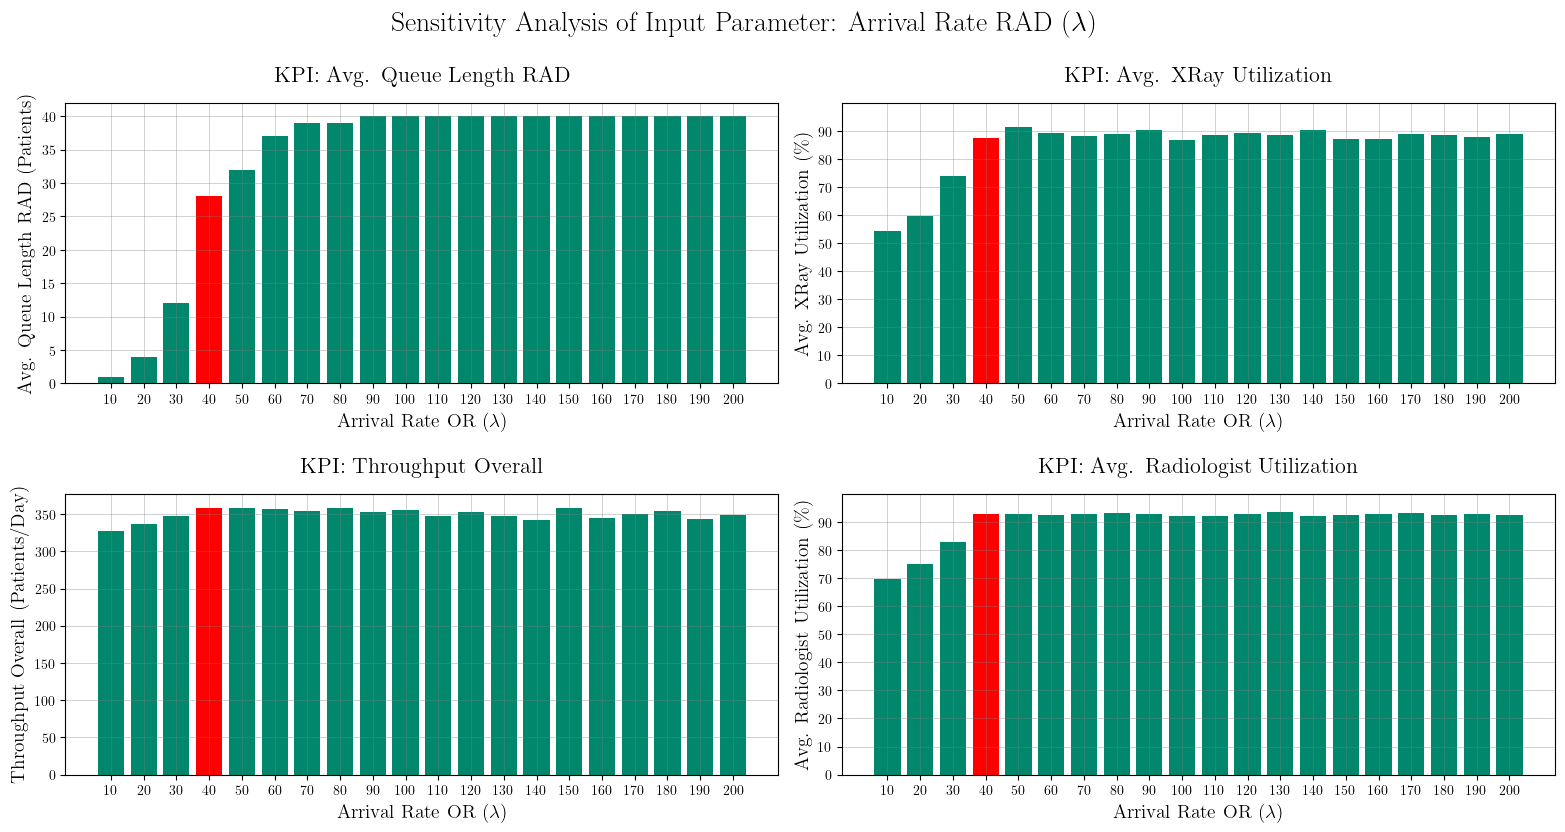

In [88]:
import os
import matplotlib.pyplot as plt

parameters = ['DailyRAD']

# Combine all MAIN KPIs
df_combined = pd.concat(
    [preprocess_data(f"{pathFiles}/{parameter}/MainKPIs/MainKPIs.csv", parameter) for parameter in parameters],
    ignore_index=True
)

def create_sensitivity_barcharts(df, parameters, kpi_columns, titles, output_dir='./sensitivity_plots/'):
    os.makedirs(output_dir, exist_ok=True)
    
    for param in parameters:
        param_data = df[df['Parameter'] == param]
        
        if param_data.empty:
            print(f"No data found for parameter: {param}")
            continue
        
        # Create a 2x2 subplot grid
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()

        fig.suptitle(f'Sensitivity Analysis of Input Parameter: Arrival Rate RAD ($\lambda$)', fontsize=20, y=1)

        
        for ax, kpi, title in zip(axes, kpi_columns, titles):

            colors = [thirdColor] * len(param_data)
            
            # Change color for the 6th bar if it exists
            bar_index = 3  # Zero-based index for the 6th bar
            if len(colors) > bar_index:
                colors[bar_index] = 'red' 

            ax.bar(range(len(param_data)), param_data[kpi], color=colors)
            ax.set_title(f'KPI: {title}', pad=15, fontsize=16)
            ax.title.set_position([0.5, 1.1])  # Adjust title position to add padding at the top
            ax.set_xlabel(f'Arrival Rate OR ($\lambda$)', fontsize=14)  # x-axis label
            ax.xaxis.set_label_coords(0.5, -0.1)  # Adjust x-axis label position
            # Set y-axis label based on KPI
            if 'Time' in title:
                ylabel = f'{title} (min)'
            elif 'Utilization' in title or 'utilization' in title:
                ylabel = f'{title} (\%)'
            elif 'Throughput' in title:
                ylabel = f'{title} (Patients/Day)'
            elif 'Rate' in title:
                ylabel = f'{title} (\%)'
            elif 'Queue' in title:
                ylabel = f'{title} (Patients)'
            elif 'EDWIN' in title:
                ylabel = 'EDWIN Score'
            else:
                ylabel = title  # default
            
            ax.set_ylabel(ylabel, fontsize=14)
            
            # Define xtick_values based on parameter
            if param == 'ArrivalED':
                xtick_values = list(range(1, 21))
            elif param in ['DailyOP', 'DailyLAB', 'DailyRAD']:
                xtick_values = list(range(10, 201, 10))
            else:
                xtick_values = param_data['Parameter'].tolist()
            
            if len(xtick_values) != len(param_data):
                print(f"Mismatch in xtick values and data length for parameter: {param}")
                xtick_values = param_data['Parameter'].tolist()
            
            ax.set_xticks(range(len(xtick_values)))
            ax.set_xticklabels(xtick_values)
            ax.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
            ax.set_facecolor('none')

            # Adjust y-axis ticks for Utilization KPIs to have exactly 10 ticks including 0.9
            if 'utilization' in title.lower():
                # Define y-axis ticks at exact multiples of 0.1
                y_ticks = np.arange(0.0, 100.0, 10)  # Creates [0.0, 0.1, ..., 0.9]
                
                ax.set_yticks(y_ticks)
                ax.set_ylim(0, 100)  # Set y-axis limits to 0 and 1
            
            #for i, v in enumerate(param_data[kpi]):
            #   ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')
        
        plt.subplots_adjust(hspace=0.3) 
        plt.tight_layout(rect=[0, 0.3, 1.05, 1.0])
        plt.savefig(f'{output_dir}{param}_sensitivity_4_figures.pdf', format='pdf', bbox_inches='tight')
        plt.show()
        plt.close()

# Create plots
create_sensitivity_barcharts(
    df=df_combined,
    parameters=parameters,
    kpi_columns=['avg_queue_length_radio', 'avg_xray_utilization', 'throughput_overall', 'avg_doctor_utilization_radio'],
    titles=['Avg. Queue Length RAD', 'Avg. XRay Utilization', 'Throughput Overall', 'Avg. Radiologist Utilization'],
)

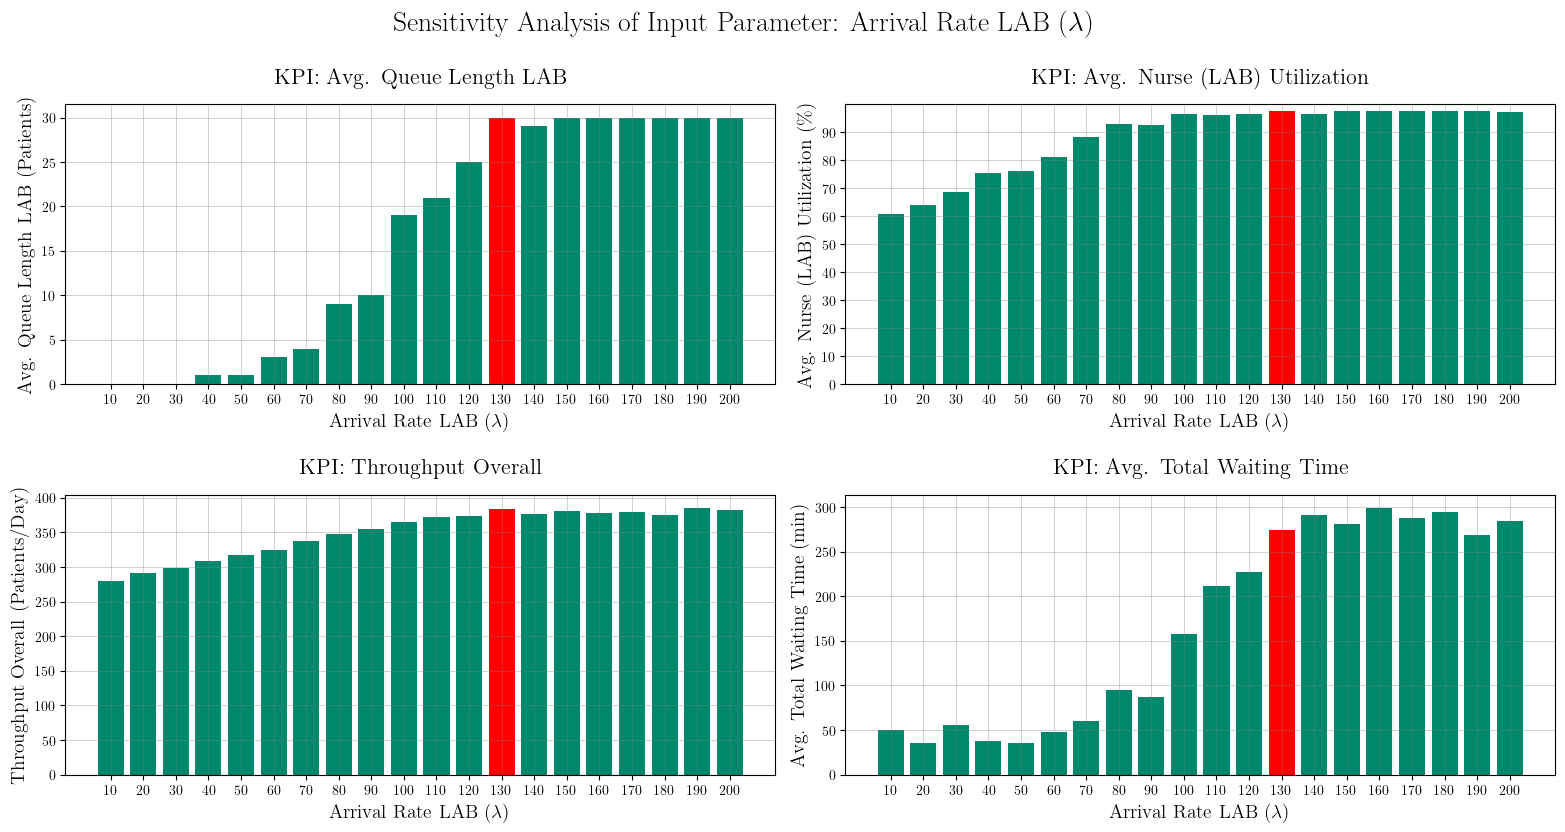

In [86]:
import os
import matplotlib.pyplot as plt

parameters = ['DailyLAB']

# Combine all MAIN KPIs
df_combined = pd.concat(
    [preprocess_data(f"{pathFiles}/{parameter}/MainKPIs/MainKPIs.csv", parameter) for parameter in parameters],
    ignore_index=True
)

def create_sensitivity_barcharts(df, parameters, kpi_columns, titles, output_dir='./sensitivity_plots/'):
    os.makedirs(output_dir, exist_ok=True)
    
    for param in parameters:
        param_data = df[df['Parameter'] == param]
        
        if param_data.empty:
            print(f"No data found for parameter: {param}")
            continue
        
        # Create a 2x2 subplot grid
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()

        fig.suptitle(f'Sensitivity Analysis of Input Parameter: Arrival Rate LAB ($\lambda$)', fontsize=20, y=1)

        
        for ax, kpi, title in zip(axes, kpi_columns, titles):

            colors = [thirdColor] * len(param_data)
            
            # Change color for the 6th bar if it exists
            bar_index = 12  # Zero-based index for the 6th bar
            if len(colors) > bar_index:
                colors[bar_index] = 'red' 

            ax.bar(range(len(param_data)), param_data[kpi], color=colors)
            ax.set_title(f'KPI: {title}', pad=15, fontsize=16)
            ax.title.set_position([0.5, 1.1])  # Adjust title position to add padding at the top
            ax.set_xlabel(f'Arrival Rate LAB ($\lambda$)', fontsize=14)  # x-axis label
            ax.xaxis.set_label_coords(0.5, -0.1)  # Adjust x-axis label position
            # Set y-axis label based on KPI
            if 'Time' in title:
                ylabel = f'{title} (min)'
            elif 'Utilization' in title or 'utilization' in title:
                ylabel = f'{title} (\%)'
            elif 'Throughput' in title:
                ylabel = f'{title} (Patients/Day)'
            elif 'Rate' in title:
                ylabel = f'{title} (\%)'
            elif 'Queue' in title:
                ylabel = f'{title} (Patients)'
            elif 'EDWIN' in title:
                ylabel = 'EDWIN Score'
            else:
                ylabel = title  # default
            
            ax.set_ylabel(ylabel, fontsize=14)
            
            # Define xtick_values based on parameter
            if param == 'ArrivalED':
                xtick_values = list(range(1, 21))
            elif param in ['DailyOP', 'DailyLAB', 'DailyRAD']:
                xtick_values = list(range(10, 201, 10))
            else:
                xtick_values = param_data['Parameter'].tolist()
            
            if len(xtick_values) != len(param_data):
                print(f"Mismatch in xtick values and data length for parameter: {param}")
                xtick_values = param_data['Parameter'].tolist()
            
            ax.set_xticks(range(len(xtick_values)))
            ax.set_xticklabels(xtick_values)
            ax.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
            ax.set_facecolor('none')

            # Adjust y-axis ticks for Utilization KPIs to have exactly 10 ticks including 0.9
            if 'utilization' in title.lower():
                # Define y-axis ticks at exact multiples of 0.1
                y_ticks = np.arange(0.0, 100.0, 10)  # Creates [0.0, 0.1, ..., 0.9]
                
                ax.set_yticks(y_ticks)
                ax.set_ylim(0, 100)  # Set y-axis limits to 0 and 1
            
            #for i, v in enumerate(param_data[kpi]):
            #   ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')
        
        plt.subplots_adjust(hspace=0.3) 
        plt.tight_layout(rect=[0, 0.3, 1.05, 1.0])
        plt.savefig(f'{output_dir}{param}_sensitivity_4_figures.pdf', format='pdf', bbox_inches='tight')
        plt.show()
        plt.close()

# Create plots
create_sensitivity_barcharts(
    df=df_combined,
    parameters=parameters,
    kpi_columns=['avg_queue_length_lab', 'avg_nurse_utilization_lab', 'throughput_overall', 'avg_total_waiting_time'],
    titles=['Avg. Queue Length LAB', 'Avg. Nurse (LAB) Utilization', 'Throughput Overall', 'Avg. Total Waiting Time'],
)